## Compare with model results and interpretability from DeepMol

Load the dataset from a CSV

In [35]:
from deepmol.compound_featurization import TwoDimensionDescriptors
from collections import Counter
from deepmol.datasets import SmilesDataset
from deepmol.loaders.loaders import CSVLoader
import pandas as pd
from deepmol.imbalanced_learn import RandomUnderSampler
from deepmol.splitters.splitters import SingletaskStratifiedSplitter
from copy import deepcopy
from deepmol.models import SklearnModel
from sklearn.ensemble import RandomForestClassifier
from deepmol.metrics import Metric
from sklearn.metrics import roc_auc_score, accuracy_score
from deepmol.feature_importance import ShapValues

In [36]:
ds = pd.read_csv('data/tox21.csv')
ds.dropna(subset=['SR-p53'],inplace=True)
ds.fillna(0, inplace=True)
ds.drop('mol_id', axis=1, inplace=True)
ds.shape

(6774, 13)

In [37]:
ds.to_csv("data/deepmol_dataset.csv", sep=',', index=True,index_label="id", encoding='utf-8')

loader = CSVLoader(dataset_path='data/deepmol_dataset.csv',
                   smiles_field='smiles',
                   id_field='id',
                   labels_fields=['SR-p53'],
                   features_fields=['NR-AR','NR-AR-LBD','NR-AhR','NR-Aromatase','NR-ER','NR-ER-LBD','NR-PPAR-gamma','SR-ARE','SR-ATAD5','SR-HSE','SR-MMP'],
                   shard_size=6774,
                   mode='auto')

In [38]:
dataset = loader.create_dataset()
dataset.get_shape()

[23:54:39] WARNING: not removing hydrogen atom without neighbors


2024-05-17 23:54:39,612 — INFO — Assuming classification since there are less than 10 unique y values. If otherwise, explicitly set the mode to 'regression'!
2024-05-17 23:54:40,106 — INFO — Mols_shape: (6774,)
2024-05-17 23:54:40,107 — INFO — Features_shape: (6774, 11)
2024-05-17 23:54:40,109 — INFO — Labels_shape: (6774,)


((6774,), (6774, 11), (6774,))

In [39]:
Counter(dataset.y)

Counter({0.0: 6351, 1.0: 423})

In [40]:
from deepmol.imbalanced_learn import RandomUnderSampler

d3 = deepcopy(dataset)
sampler = RandomUnderSampler(sampling_strategy=0.75, random_state=123, replacement=True)
d3 = sampler.sample(d3)

Counter(d3.y)   

Counter({0.0: 564, 1.0: 423})

In [41]:
splitter = SingletaskStratifiedSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=d3, frac_train=0.7,
                                                                             frac_valid=0.15, frac_test=0.15)

In [42]:
rf = RandomForestClassifier()
model = SklearnModel(model=rf)
model.fit(train_dataset)

SklearnModel(model=RandomForestClassifier(),
             model_dir='C:\\Users\\joaop\\AppData\\Local\\Temp\\tmp_41izpst')

In [43]:
model.evaluate(test_dataset, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])

({'roc_auc_score': 0.7517463235294117, 'accuracy_score': 0.7718120805369127},
 {})

In [44]:
from deepmol.compound_featurization import ConvMolFeat

train_dataset_conv = ConvMolFeat(n_jobs=10).featurize(train_dataset, inplace=False)
test_dataset_conv = ConvMolFeat(n_jobs=10).featurize(test_dataset, inplace=False)
valid_dataset_conv = ConvMolFeat(n_jobs=10).featurize(valid_dataset, inplace=False)


In [45]:
from deepchem.models import GraphConvModel
from deepmol.models import DeepChemModel

model1 = DeepChemModel(model=GraphConvModel, epochs=100, verbose=1, n_tasks=1, graph_conv_layers=[32, 32], dense_layer_size=128)
model1.fit(train_dataset_conv)

In [46]:
model1.evaluate(test_dataset_conv, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])

({'roc_auc_score': 0.7126838235294117, 'accuracy_score': 0.738255033557047},
 {})

In [47]:
model1.evaluate(valid_dataset_conv, metrics=[Metric(metric=roc_auc_score), Metric(metric=accuracy_score)])

({'roc_auc_score': 0.7586367880485527, 'accuracy_score': 0.777027027027027},
 {})

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but Ran

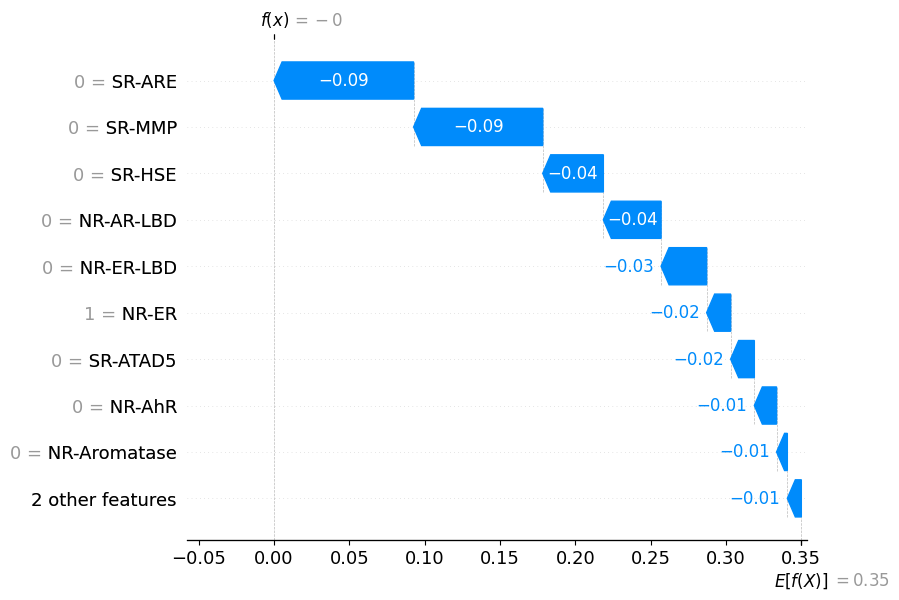

In [48]:
# compute shap values
shap_calc = ShapValues()
shap_calc.fit(train_dataset, model)
shap_calc.sample_explanation_plot(index=1, plot_type='waterfall')

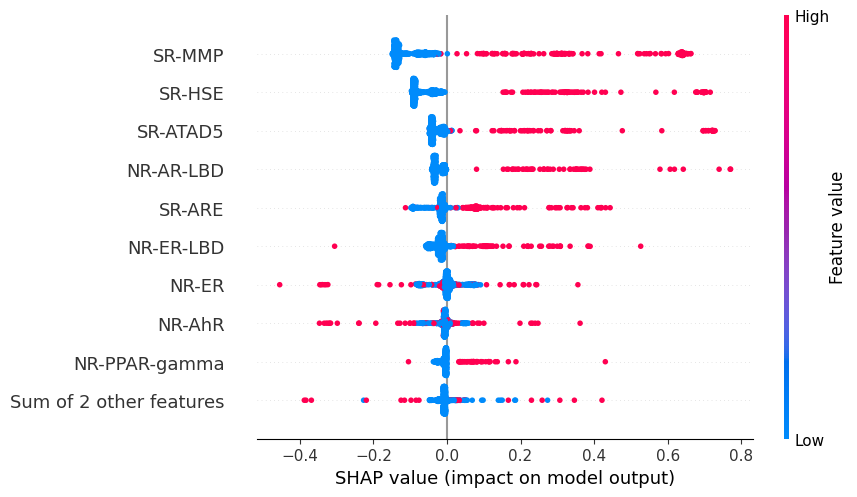

In [55]:
shap_calc.beeswarm_plot()

In [49]:
from deepmol.compound_featurization import MACCSkeysFingerprint

patt_number = 66
mol_number = 2

prediction = model1.predict(test_dataset_conv)[mol_number]
actual_value = test_dataset_conv.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi_conv = test_dataset_conv.mols[mol_number]

maccs_keys = MACCSkeysFingerprint()

maccs_keys.draw_bit(smi_conv, patt_number)

Prediction:  0
Actual Value:  0.0
2024-05-18 00:04:01,316 — INFO — Pattern does not match molecule! Active bits: [ 32  33  36  47  51  52  55  58  59  60  61  64  65  67  69  73  74  77
  79  80  81  83  88  91  93  94  96  97 102 106 111 112 113 115 117 120
 121 124 125 126 127 130 133 135 136 137 141 142 143 146 148 149 151 152
 155 156 157 158 159 160 161 162 163 164 165]


2024-05-18 00:04:01,345 — INFO — Bit 80 with 1 hits!


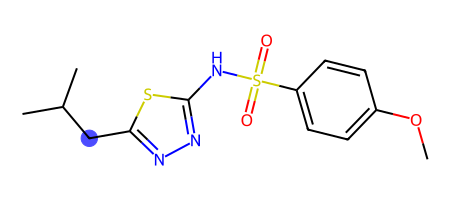

In [50]:
patt_number = 80
from deepmol.compound_featurization import MorganFingerprint
MorganFingerprint().draw_bit(smi_conv, patt_number)

2024-05-18 00:04:01,390 — INFO — Bit 389 is off!
2024-05-18 00:04:01,393 — INFO — Bit 807 is off!
2024-05-18 00:04:01,396 — INFO — Bit 930 is off!
2024-05-18 00:04:01,398 — INFO — Bit 1138 is off!


2024-05-18 00:04:01,400 — INFO — Bit 1141 is off!
2024-05-18 00:04:01,401 — INFO — Bit 1290 is off!
2024-05-18 00:04:01,403 — INFO — Bit 1531 is off!
2024-05-18 00:04:01,404 — INFO — Bit 1737 is off!
2024-05-18 00:04:01,405 — INFO — Bit 1844 is off!
2024-05-18 00:04:01,406 — INFO — Bit 1876 is off!
2024-05-18 00:04:01,407 — INFO — Bit 1917 is off!
2024-05-18 00:04:01,411 — INFO — Using only bits ON: [1, 80, 650]


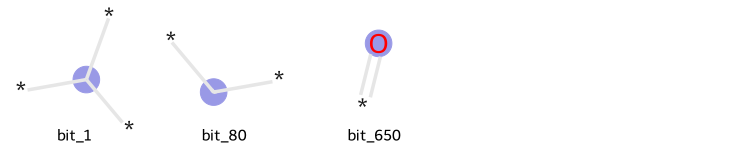

In [51]:
MorganFingerprint().draw_bits(smi_conv, [1, 80, 389, 650, 807, 930, 1138, 1141, 1290, 1531, 1737, 1844, 1876, 1917])

Prediction:  0.0
Actual Value:  0.0


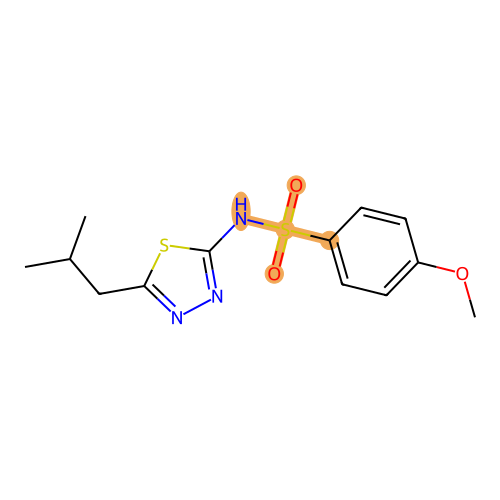

In [52]:
patt_number = 112 
mol_number = 2

prediction = model.predict(test_dataset)[mol_number]
actual_value = test_dataset.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi = test_dataset.mols[mol_number]

maccs_keys = MACCSkeysFingerprint()

maccs_keys.draw_bit(smi, patt_number)

2024-05-18 00:04:01,543 — INFO — Bit 1 with 1 hits!


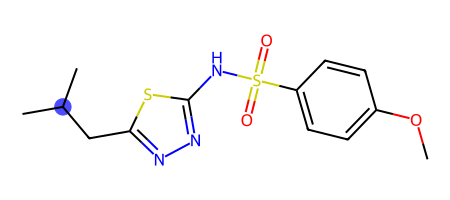

In [53]:
patt_number = 1
MorganFingerprint().draw_bit(smi, patt_number)

2024-05-18 00:04:01,573 — INFO — Bit 389 is off!
2024-05-18 00:04:01,575 — INFO — Bit 807 is off!
2024-05-18 00:04:01,577 — INFO — Bit 930 is off!
2024-05-18 00:04:01,579 — INFO — Bit 1138 is off!
2024-05-18 00:04:01,581 — INFO — Bit 1141 is off!
2024-05-18 00:04:01,582 — INFO — Bit 1290 is off!
2024-05-18 00:04:01,583 — INFO — Bit 1531 is off!
2024-05-18 00:04:01,585 — INFO — Bit 1737 is off!
2024-05-18 00:04:01,587 — INFO — Bit 1844 is off!
2024-05-18 00:04:01,589 — INFO — Bit 1876 is off!
2024-05-18 00:04:01,590 — INFO — Bit 1917 is off!
2024-05-18 00:04:01,592 — INFO — Using only bits ON: [1, 80, 650]


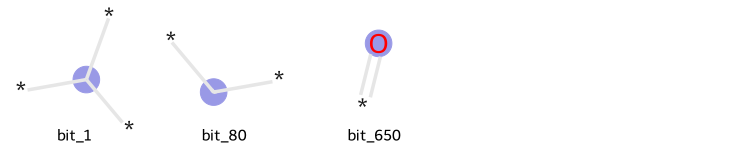

In [54]:
MorganFingerprint().draw_bits(smi,  [1, 80, 389, 650, 807, 930, 1138, 1141, 1290, 1531, 1737, 1844, 1876, 1917])